<a href="https://colab.research.google.com/github/onefemi/Machine_Learning_project/blob/main/Malaria_Cell_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Malaria Cell Image Detention Using CNN

Load all required libraries

In [ ]:
%matplotlib inline
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from PIL import Image
from tensorflow.keras.optimizers import Adam
from random import randrange

import shutil, sys

from shutil import copytree, move, rmtree

Install Kaggle, as the dataset is located on Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the dataset from kaggle to the cloud drive

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download iarunava/cell-images-for-detecting-malaria

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 660M/675M [00:02<00:00, 270MB/s]
100% 675M/675M [00:02<00:00, 269MB/s]


Unzip the archive to extract the contents

In [ ]:
! unzip cell-images-for-detecting-malaria

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

Here the root directory of the cell images is outlined and stored in directories variable

Result are ['Parasitized', 'Uninfected']

In [ ]:
import os

train = 'cell_images/cell_images'

# Get all subdirectories of data directory "train" folder. Each subdirectory represents a label.
directories = [d for d in os.listdir(train) if os.path.isdir(os.path.join(train, d))]
directories

['Parasitized', 'Uninfected']

Perform Exploratory analysis on Dataset

Check the size of the images in the dataset

Check the blurriness of the images in the dataset

Check the color distribution of the images in the dataset

Check whether there is class imbalance


Image count, shape and size

In [ ]:
#Count the number of images

INF_DIR = os.path.join('/content/cell_images/cell_images', 'Parasitized')
UNINF_DIR = os.path.join('/content/cell_images/cell_images', 'Uninfected')

inf_fnames = [os.path.join(INF_DIR, f) for f in os.listdir(INF_DIR) if f.endswith('.png')]
uninf_fnames = [os.path.join(UNINF_DIR, f) for f in os.listdir(UNINF_DIR) if f.endswith('.png')]

print(f'Amount of parasitized images: {len(inf_fnames)}')
print(f'Amount of uninfected images: {len(uninf_fnames)}')
print(f'Total Images: {len(inf_fnames) + len(uninf_fnames)}')

Amount of parasitized images: 13779
Amount of uninfected images: 13779
Total Images: 27558


Text(0.5, 0, 'Uninfected')

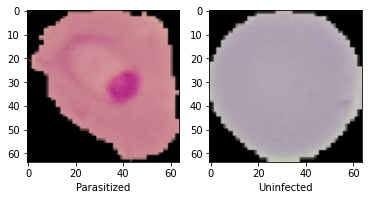

In [ ]:
#Plotting a sample image
img_size = 64
dim = img_size, img_size

inf = os.path.join(os.path.join(INF_DIR, inf_fnames[0]))
uninf = os.path.join(os.path.join(UNINF_DIR, uninf_fnames[0]))

img_inf = cv2.imread(inf)
img_uninf = cv2.imread(uninf)

img_inf = cv2.cvtColor(img_inf, cv2.COLOR_BGR2RGB)

img_uninf = cv2.cvtColor(img_uninf, cv2.COLOR_BGR2RGB)

img_uninf = cv2.resize(img_uninf, dim)
img_inf = cv2.resize(img_inf, dim)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_inf)
axarr[1].imshow(img_uninf)

axarr[0].set_xlabel('Parasitized')
axarr[1].set_xlabel('Uninfected')

In [ ]:
#Shape of sample infected and uninfected
imageinf = cv2.imread(os.path.join(INF_DIR, inf_fnames[0]))
imageuninf = cv2.imread(os.path.join(UNINF_DIR, uninf_fnames[0]))
height_i, width_i, shape_i = imageinf.shape
height_u, width_u, shape_u = imageuninf.shape
print("infected: ", height_i, width_i, shape_i)
print("uninfected: ", height_u, width_u, shape_u)

infected:  142 112 3
uninfected:  121 118 3


Uniqueness of shape count

In [ ]:
#Getting uniques shape count of all image in the dataset
import cv2

dataset_folder = '/content/cell_images/cell_images'
folders = os.listdir(dataset_folder)
images = []
image_shapes = []
for folder in folders:
  folder_path = os.path.join(dataset_folder, folder)
  for path in os.listdir(folder_path):
    if path.endswith('.png'):
      image_path = os.path.join(os.path.join(dataset_folder, folder), path)
      #print(image_path)
      image = cv2.imread(image_path)

      # Convert to RGB
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      images.append(image)

      #Store shape of each image in an array
      (width, height) = image.shape[1], image.shape[0]
      image_shapes.append((width, height))


# Return only unique shapes
unique_shapes = list(set(image_shapes))
print('Number cell images with unique shapes: ', len(unique_shapes))

Number cell images with unique shapes:  1627


Checking for Blur images

In [ ]:
#function to check blurness
def blurrness(image):
  return cv2.Laplacian(image, cv2.CV_64F).var()

#assigned threshold for blurness in image
blur_threshold = 1000

#checking all images
folders = os.listdir(dataset_folder)
image_var = []
blur_image = []
for folder in folders:
  folder_path = os.path.join(dataset_folder, folder)
  for path in os.listdir(folder_path):
    image_path = os.path.join(os.path.join(dataset_folder, folder), path)
    image_var.append(blurrness(image))
    if(blurrness(image) < blur_threshold):
        blur_image.append(image)
    #print('path variance: ', path, variance_of_laplacian(image))

print('Number of blur images: ',len(blur_image))

Number of blur images:  0


Color distribution of images

Text(0.5, 0, 'Blue')

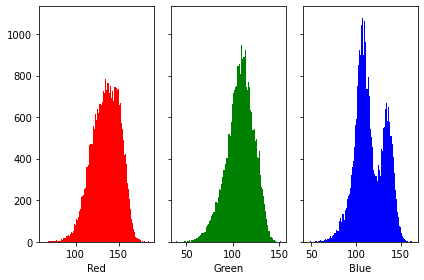

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obtain the mean of the R channel of the RGB space of the image
mean_r_values = []
for i in range(len(images)):
  mean_r_value = np.mean(images[i][:, :, 0])
  mean_r_values.append(mean_r_value)

# Obtain the mean of the G channel of the RGB space of the image
mean_g_values = []
for i in range(len(images)):
  mean_g_value = np.mean(images[i][:, :, 1])
  mean_g_values.append(mean_g_value)

# Obtain the mean of the B channel of the RGB space of the image
mean_b_values = []
for i in range(len(images)):
  mean_b_value = np.mean(images[i][:, :, 2])
  mean_b_values.append(mean_b_value)

# Obtain the mean of all channels of the RGB space of the image
mean_values = []
for i in range(len(images)):
  mean_value = np.mean(images[i])
  mean_values.append(mean_value)

#Round means and removing duplicates
mean_r_values = [round(num, 1) for num in mean_r_values]
mean_g_values = [round(num, 1) for num in mean_g_values]
mean_b_values = [round(num, 1) for num in mean_b_values]

# the histogram of the data
#plotr = plt.hist(mean_r_values, 100, density=True, facecolor='g', alpha=0.75)
#plotg = plt.hist(mean_g_values, 100, density=True, facecolor='g', alpha=0.75)
#plotb = plt.hist(mean_b_values, 100, density=True, facecolor='g', alpha=0.75)


# Generate two normal distributions
dist1 = mean_r_values
dist2 = mean_g_values
dist3 = mean_b_values

n_bins = 100

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

#Histogram of Mean Color(RGB) distribution'
axs[0].hist(dist1, bins=n_bins, color='red')
axs[1].hist(dist2, bins=n_bins, color='green')
axs[2].hist(dist3, bins=n_bins, color='blue')

axs[0].set_xlabel('Red')
axs[1].set_xlabel('Green')
axs[2].set_xlabel('Blue')

Preprocessing the dataset

Resizing all images to 64 x 64 resolution

Generating the labels and images list


In [ ]:
import cv2 # computer vision package we've used before
import numpy as np

# Loop through the label subdirectories and collect the data in two lists,
# one list for labels themselves and one list for the images inside those label folders.
labels = []
images = []

category = 0 # this is tp label the data baased on the subdirectory number
for d in directories:
    label_dir = os.path.join(train, d)
    # get all the image files (all .jpg) in each subdirectory
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]

    # counter = 0 # I put this counter in order to work on a part of the images coz it takes a while
    for f in file_names:
        img = cv2.imread(f)
        imresize = cv2.resize(img, (64, 64))
        images.append(imresize)
        labels.append(category)
        #if counter > 50:  # remove this to use full dataset
            #break
        #counter += 1

    category += 1 # we increment when finishing the subdirectory before moving to another subdirectory for another fish type

In [ ]:
#printing out the new shape
images = np.array(images)
images.shape

(27558, 64, 64, 3)

In [ ]:
#printing out the number of labels
labels = np.array(labels)
labels.shape

(27558,)

In [ ]:
#Splitting to train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1234)

In [ ]:
#Printing out the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22046, 64, 64, 3)
(22046,)
(5512, 64, 64, 3)
(5512,)


In [ ]:
from tensorflow.keras.utils import to_categorical

#RGB values range from 0 to 255,normalize inputs from [0.0, 255.0]
#to end up with input in the range [0.0, 1.0]
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding of the labels
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(y_train.shape)

(22046, 2)


In [ ]:
num_classes = y_train.shape[1]
print(num_classes)

2


Building a Convolutional neural network model and training it

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

# Create the model
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

# Compile model
#epochs = 25  # >>> should be 25+
#lr = 0.01 # learning rate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=3)
epochs=20
seed = 1234
np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[callback])


print(len(history.history['loss']))

Epoch 1/20
689/689 [==============================] - 9s 11ms/step - loss: 0.3990 - acc: 0.8347 - val_loss: 0.3442 - val_acc: 0.8828
Epoch 2/20
689/689 [==============================] - 7s 11ms/step - loss: 0.1838 - acc: 0.9408 - val_loss: 0.1429 - val_acc: 0.9501
Epoch 3/20
689/689 [==============================] - 7s 10ms/step - loss: 0.1734 - acc: 0.9430 - val_loss: 0.1875 - val_acc: 0.9363
Epoch 4/20
689/689 [==============================] - 7s 10ms/step - loss: 0.1617 - acc: 0.9469 - val_loss: 0.1387 - val_acc: 0.9534
Epoch 5/20
689/689 [==============================] - 7s 10ms/step - loss: 0.1556 - acc: 0.9490 - val_loss: 0.1394 - val_acc: 0.9514
Epoch 6/20
689/689 [==============================] - 7s 10ms/step - loss: 0.1548 - acc: 0.9475 - val_loss: 0.1812 - val_acc: 0.9370
Epoch 7/20
689/689 [==============================] - 7s 10ms/step - loss: 0.1536 - acc: 0.9507 - val_loss: 0.1245 - val_acc: 0.9588
Epoch 8/20
689/689 [==============================] - 7s 10ms/step - 

Evaluting the Results

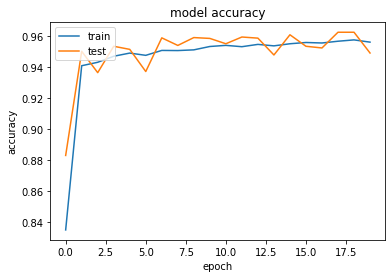

In [ ]:
# Accuracy Plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

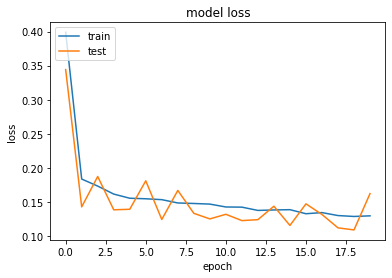

In [ ]:
# Lossness Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape)
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.97      0.92      0.95      2730
  Uninfected       0.93      0.98      0.95      2782

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



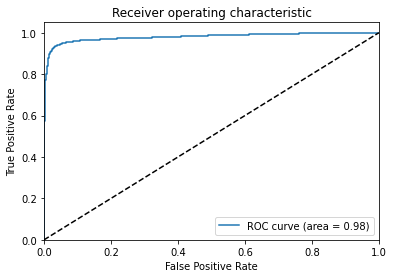

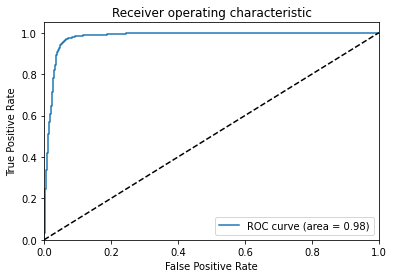

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) # get the prediction probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Loading a preprocessed model VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(64, 64, 3), # your input_shape preferablly to have the same as the original pretrained model
    include_top=False)  # Do not include the ImageNet classifier at the top.

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# Step 3: Create your model on top
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D

inputs = Input(shape=(64, 64, 3))
x = base_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

Fineturning

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    # Create the model
    model = Sequential()
    model.add(Conv2D(hp.Choice('filters', [8, 16, 32]), kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) # num_classes = 8
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# Step 2: use RandomSearch from keras_tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

In [ ]:
# Step 3: start the search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]